TCN

### Focus on Electrode 5

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import numpy as np
import json
import pandas as pd
import numpy as np
import time
import string
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.append('../../../')
from brain2brain import utils, generators, models
from brain2brain.tcn import TCN


%matplotlib inline

# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# TCN
from brain2brain.tcn import TCN
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, GRU, LSTM, RepeatVector, TimeDistributed, Lambda

from scipy.stats import pearsonr

from brain2brain import utils, models

In [3]:
train_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/train_676_bin_norm_2.txt")
val_bin_norm_paths = utils.get_file_paths("/home/tmarcu/brain2brain/brain2brain/val_676_bin_norm_2.txt")
total_electrode_count = utils.get_file_shape(train_bin_norm_paths[0])[1]
# Electrodes
electrode_count = 114
electrode = 5
electrodes = range(114)
lookback = 200
length_pred = 30
# Training Generator
train_generator = generators.FGenerator(file_paths=train_bin_norm_paths,
                                        lookback=lookback,
                                        length=length_pred,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=electrodes,
                                        electrode_output_ix=electrode,
                                        shuffle=True)
# Validation Generator
val_generator = generators.FGenerator(file_paths=val_bin_norm_paths,
                                        lookback=lookback,
                                        length=length_pred,
                                        delay=0,
                                        batch_size=1024,
                                        sample_period=1,
                                        electrodes=electrodes,
                                        electrode_output_ix=electrode,
                                        shuffle=False)

(5429, 114)


In [4]:
train_generator[0][0].shape

(1024, 200, 114)

In [5]:
val_generator[0][1].shape

(1024, 30, 1)

In [6]:
val_generator[0][0].shape

(1024, 200, 114)

In [7]:
# Model Architecture
input_layer = Input(shape=(None, electrode_count))
x = TCN(nb_filters=32,
        kernel_size=4,
        dilations=[1, 2, 4, 8, 16],
        nb_stacks=2,
        padding="causal",
        use_skip_connections=True,
        return_sequences=True,
        activation="linear",
        dropout_rate=0.05,
        kernel_initializer="he_normal")(input_layer)
x = Dense(1)(x)
# Workaround because config does not work with copy.deepcopy
# https://github.com/wandb/client/issues/833 fix does not work
x = Lambda(lambda x: x[:, -length_pred:, :])(x)
output_layer = x
model = Model(input_layer, output_layer)
model.compile(optimizer=Adam(), loss="mae")
model.summary()

(None, None, 114)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 114)]       0         
_________________________________________________________________
tcn (TCN)                    (None, None, 32)          95744     
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 95,777
Trainable params: 95,777
Non-trainable params: 0
_________________________________________________________________


In [8]:
callback_list = [
#         EarlyStopping(
#             monitor="val_loss",
#             patience=5,
#             mode="min"
#         )
]
history = model.fit_generator(generator=train_generator,
                              callbacks=callback_list,
                              epochs=100,
                              validation_data=val_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6 steps, validate for 2 steps
Epoch 1/100
6/6 [==============================] - 12s 2s/step - loss: 98.8864 - val_loss: 36.7661
Epoch 2/100
6/6 [==============================] - 4s 642ms/step - loss: 37.7996 - val_loss: 19.3578
Epoch 3/100
6/6 [==============================] - 4s 653ms/step - loss: 21.8974 - val_loss: 12.6516
Epoch 4/100
6/6 [==============================] - 4s 641ms/step - loss: 14.7732 - val_loss: 9.0074
Epoch 5/100
6/6 [==============================] - 4s 641ms/step - loss: 10.9554 - val_loss: 7.0362
Epoch 6/100
6/6 [==============================] - 4s 640ms/step - loss: 8.5371 - val_loss: 5.7017
Epoch 7/100
6/6 [==============================] - 4s 642ms/step - loss: 6.9896 - val_loss: 4.6715
Epoch 8/100
6/6 [==============================] - 4s 640ms/step - loss: 5.8447 - val_loss: 4.0023
Epoch 9/100
6/6 [===================

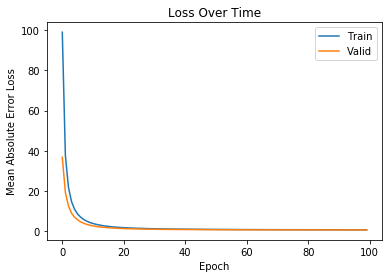

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

# Evaluate Sequences

In [10]:
from tensorflow.keras.models import model_from_json

file_name = "models/tcn_m2o_2"
# serialize model to JSON
model_json = model.to_json()
with open(f"{file_name}.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(f"{file_name}.h5")


NameError: name 'model' is not defined

In [7]:
from tensorflow.keras.models import model_from_json
file_name = "models/tcn_m2o_2"

# load json and create model
json_file = open(f'{file_name}.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json, custom_objects={'TCN': TCN})
# load weights into new model
model.load_weights(f"{file_name}.h5")
print("Loaded model from disk")

(None, None, 114)
Loaded model from disk


In [12]:
val_generator[0][1].shape

(1024, 30, 1)

In [13]:
def predict_and_plot(model,
                     input_sequnece_batch,
                     target_sequence_batch,
                     sample_ix,
                     pred_steps: int,
                     enc_tail_len=200):
    input_sequence = input_sequnece_batch[sample_ix]
    target_sequence = target_sequence_batch[sample_ix]
    pred_series = models.predict_sequence_m2o(input_sequence,
                                              pred_steps, model, 114)
    input_sequence = input_sequence.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_sequence = target_sequence.reshape(pred_steps,1)
    print(target_sequence.shape)
    input_sequence_tail = np.concatenate([input_sequence[-enc_tail_len:],target_sequence[:1]])
    x_encode = input_sequence_tail.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), target_sequence.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_sequence.reshape(-1))) 
    print(f"Correlation: {r}. P: {p}. MAE {mae}")
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1), input_sequence_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_sequence,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])


(30, 1)
Correlation: 0.07897652488242597. P: 0.6782585928062521. MAE 0.7290668629919499


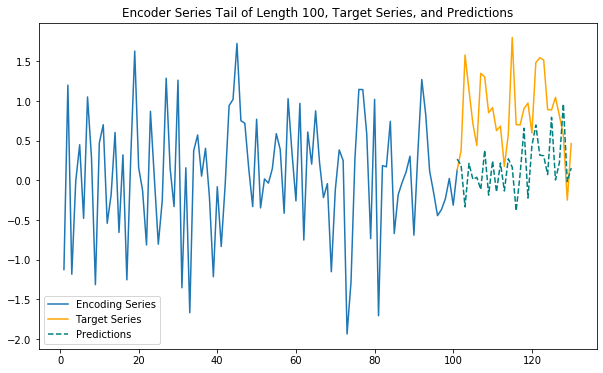

In [14]:
predict_and_plot(model, val_generator[0][0], val_generator[0][1],
                 0, pred_steps = length_pred, enc_tail_len=100)

(30, 1)
Correlation: -0.08744894378279336. P: 0.6458700316743727. MAE 0.7524286927924434


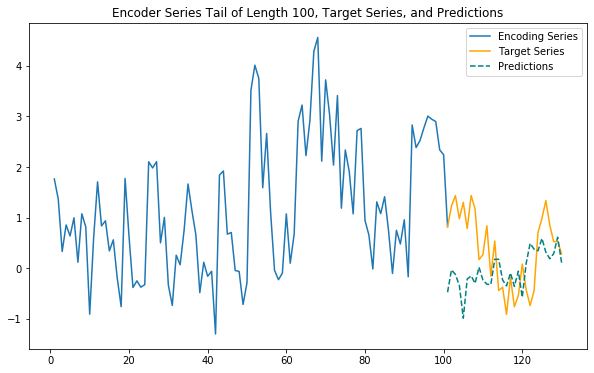

In [15]:
predict_and_plot(model, val_generator[0][0], val_generator[0][1],
                 1, pred_steps = length_pred, enc_tail_len=100)

In [16]:
def get_corr_mae(model,
                 input_sequnece_batch,
                 target_sequence_batch,
                 sample_ix,
                 pred_steps: int,
                 enc_tail_len=100,
                 verbose=True):
    input_sequence = input_sequnece_batch[sample_ix]
    target_sequence = target_sequence_batch[sample_ix]
    pred_series = models.predict_sequence_m2o(input_sequence,
                                              pred_steps, model, 114)
    input_sequence = input_sequence.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_sequnece = target_sequence.reshape(pred_steps,1)
    input_sequence_tail = np.concatenate([input_sequence[-enc_tail_len:],target_sequence[:1]])
    x_encode = input_sequence_tail.shape[0]
    
    r, p = pearsonr(pred_series.reshape(-1), target_sequence.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - target_sequence.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    return r, mae

In [17]:
get_corr_mae(model, val_generator[0][0], val_generator[0][1],
                 1, pred_steps = 30)

Correlation: -0.08744894378279336. P: 0.6458700316743727. MAE: 0.7524286927924434


(-0.08744894378279336, 0.7524286927924434)

Calculating MAE/CORR per batch.
Batch_r: -0.013675276099686337
Absolute Batch_r: 0.16869024356527154
Batch Mae: 0.6885536329668485


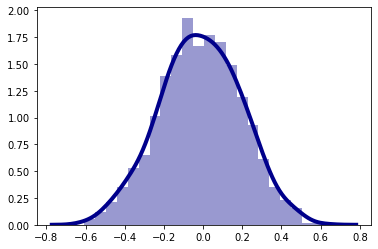

In [18]:
print("Calculating MAE/CORR per batch.")
batch_ix = 0
val_batch = val_generator[batch_ix] 
n_rows = val_batch[0].shape[0]
r_array = np.empty(shape=(n_rows,))
z_array = np.empty(shape=(n_rows,))
sample_maes = np.empty(shape=(n_rows,))
for sample_ix in range(n_rows):
    print(f"Sample: {sample_ix}/{n_rows}", end="\r")
    r, mae = get_corr_mae(model, val_batch[0], val_batch[1],
                                sample_ix=sample_ix, pred_steps=30, verbose=False)
    r_array[sample_ix] = r
    z_array[sample_ix] = 0.5 * np.log((1 + r)/(1-r))
    sample_maes[sample_ix] = mae
z_mean = np.mean(z_array)
batch_r = (np.exp(2 * z_mean) - 1)/(np.exp(2 * z_mean) + 1)
batch_mae = np.mean(sample_maes)
print(f"Batch_r: {batch_r}")
print(f"Absolute Batch_r: {np.mean(np.abs(r_array))}")
print(f"Batch Mae: {batch_mae}")


# Plot the distribution of r
import seaborn as sns
sns.distplot(r_array, kde=True, color = 'darkblue',
             kde_kws={'linewidth': 4})

In [20]:
k = 5
top_k_r = np.abs(r_array).argsort()[-k:]
print(top_k_r)

[893  54  80 827 950]


(30, 1)
Correlation: -0.5462597297238586. P: 0.0017906987027255736. MAE 0.849829164439377
(30, 1)
Correlation: -0.5671228768714605. P: 0.0010831935256063894. MAE 1.0382660036964986
(30, 1)
Correlation: -0.5997478219184247. P: 0.00046025431368825. MAE 0.7351737542909993
(30, 1)
Correlation: -0.6070981630468315. P: 0.00037468023471033175. MAE 1.0038694597683913
(30, 1)
Correlation: 0.6161213794942833. P: 0.0002890383805903323. MAE 0.6802988394805567


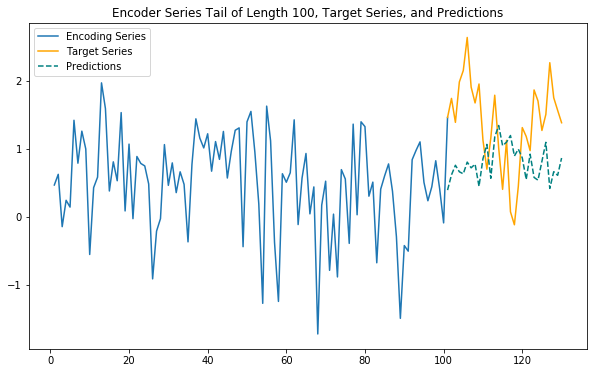

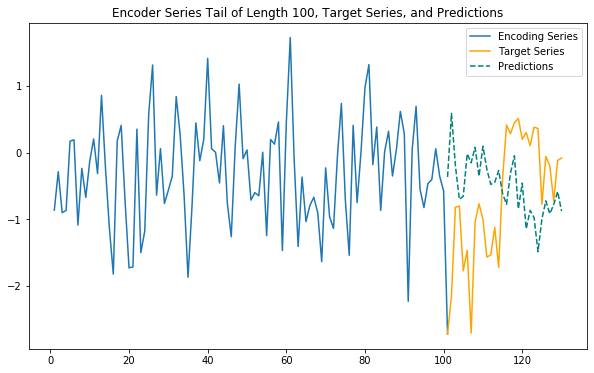

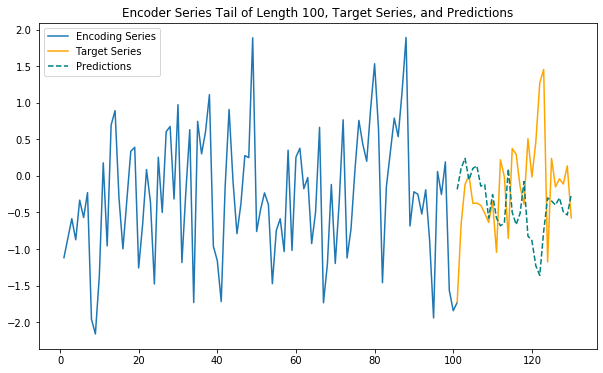

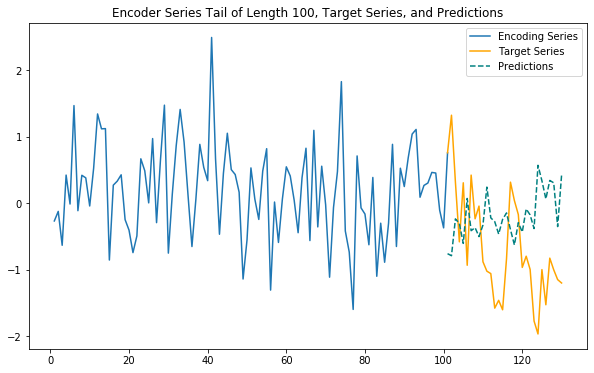

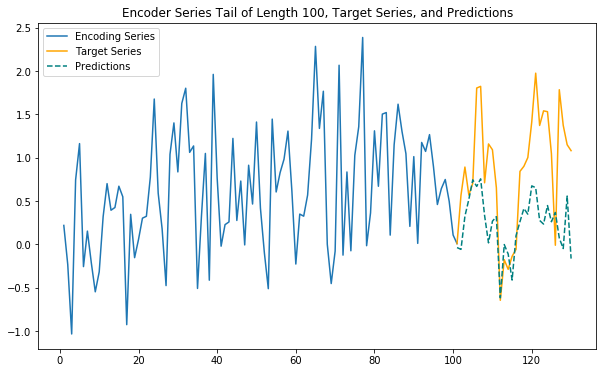

In [23]:
for i in top_k_r:
    predict_and_plot(model, val_batch[0], val_batch[1], sample_ix=i,
                     pred_steps=30, enc_tail_len=100)

In [24]:
k = 5
top_k_mae = sample_maes.argsort()[:k]
print(top_k_mae)

[861 672 518  29 746]


(30, 1)
Correlation: 0.25043817206400265. P: 0.1819393509066957. MAE 0.35842586927491543
(30, 1)
Correlation: 0.29790353043337464. P: 0.10984351010613025. MAE 0.3667498621001559
(30, 1)
Correlation: 0.2616595534595423. P: 0.16249048667676283. MAE 0.3703882375335592
(30, 1)
Correlation: 0.2771533369825201. P: 0.13814033812342233. MAE 0.37180718774738136
(30, 1)
Correlation: 0.33843435065977484. P: 0.06735132912744891. MAE 0.37387601459022163


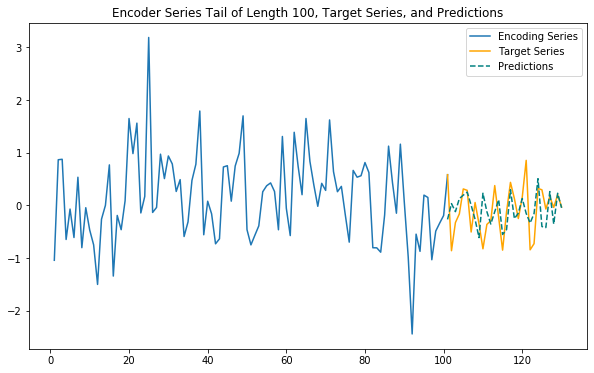

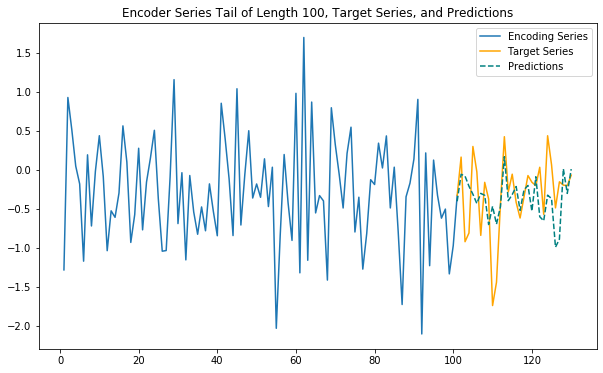

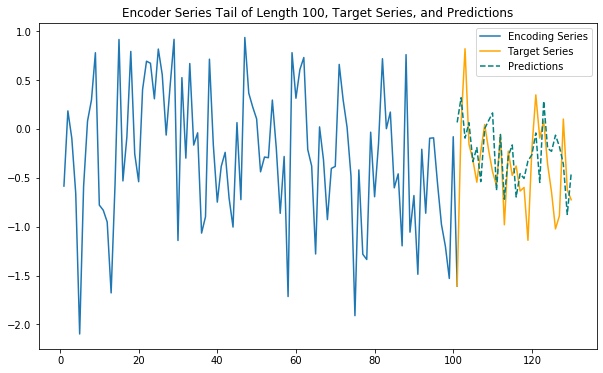

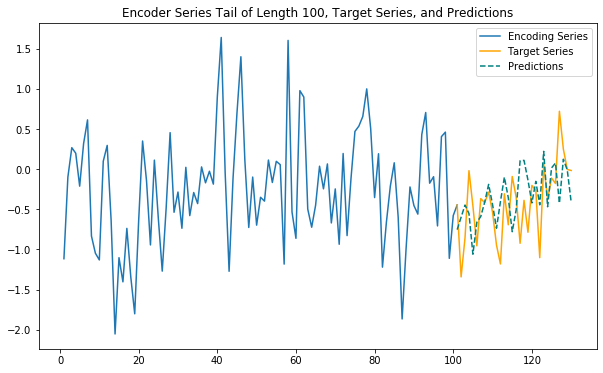

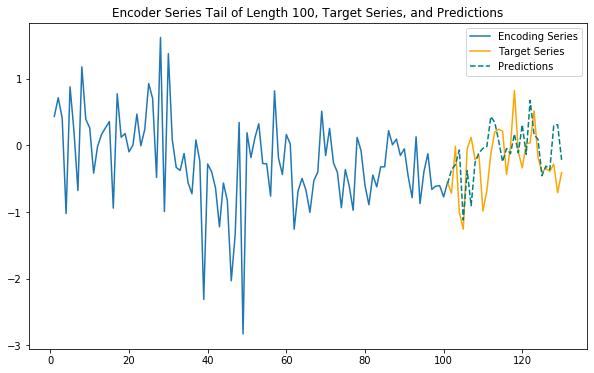

In [25]:
for i in top_k_mae:
    predict_and_plot(model, val_batch[0], val_batch[1], sample_ix=i,
                     pred_steps=30, enc_tail_len=100)

In [8]:
target_electrode=electrode
lookback=100
pred_length=20
val_paths = val_bin_norm_paths

In [9]:


def predict_sequence_m2o_window(input_sequence,
                                history_sequence_target,
                                pred_steps,
                                target_electrode,
                                electrodes,
                                model=model,
                                lookback=lookback):
    electrode_count = len(electrodes)
    pred_sequence = np.zeros((pred_steps,)) # initialize output (pred_steps time steps)  
    history_sequence = input_sequence
    history_sequence_target = np.array([history_sequence_target])

#     print(history_sequence.shape)

    for i in range(pred_steps):
        # record next time step prediction (last time step of model output) 
        history_sequence = history_sequence.reshape((1, lookback, len(electrodes)))
#         print(history_sequence.shape)
        last_step_pred = model.predict(history_sequence)
#         last_step_pred = last_step_pred.reshape(-1)
        
        pred_sequence[i] = last_step_pred[:, -1, :]
#         print(pred_sequence.shape)
        history_sequence_target[0, i, electrode] = pred_sequence[i]
#         print(history_sequence_target.shape)
#         print(history_sequence_target[:, i, electrode].shape)
#         print(history_sequence_target[:, i, :].shape)
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence[:, -(lookback-1):, :], 
                                           history_sequence_target[:, i, :].reshape(1, 1, electrode_count)], axis=1)
#     print(len(pred_sequence))
    return pred_sequence

def moving_window_pred_m2o(input_sequence,
                           lookback,
                           pred_steps,
                           electrode_count,
                           electrodes,
                           target_electrode,
                           model):
    # for each window of lookback predict steps and then
    # move window up by pred steps and repeat
    # window = input_sequence[w_start: w_end]
    final_array = np.empty(shape=(input_sequence.shape[0], 1))
    print(final_array.shape)
    w_start = 0
    w_end = w_start + lookback
    final_array[w_start : w_end] = input_sequence[w_start : w_end, target_electrode].reshape(lookback, 1)
    history_sequence_target = input_sequence
    while w_end + pred_steps < input_sequence.shape[0]:
        window_lookback = input_sequence[w_start: w_end, electrodes]
        pred_seq = predict_sequence_m2o_window(window_lookback,
                                               history_sequence_target,
                                               pred_steps,
                                               target_electrode = target_electrode,
                                               electrodes = electrodes,
                                               model=model,
                                               lookback=lookback)
#         print(pred_seq.shape)
        final_array[w_end:w_end+pred_steps] = pred_seq.reshape(pred_steps, 1)
        w_start += pred_steps
        w_end += pred_steps
    return final_array

def get_corr_mae_conv(input_seq,
                      lookback,
                      pred_length,
                      electrode_count,
                      electrodes,
                      target_electrode,
                      model,
                      enc_tail_len=100,
                      verbose=True):
    
    
    print(input_seq.shape)
    input_seq = input_seq[:,[*electrodes]].reshape(input_seq.shape[0], electrode_count)

    predicted_series = moving_window_pred_m2o(input_seq,
                                              lookback = lookback,
                                              pred_steps = pred_length,
                                              target_electrode=target_electrode,
                                              electrodes = electrodes,
                                              electrode_count=electrode_count,
                                              model=model)
    
    input_seq = input_seq[lookback:, target_electrode]
    print(input_seq.shape)
    predicted_series = predicted_series[lookback:,:]

    input_series = input_seq.reshape(-1,1)
    pred_series = predicted_series.reshape(-1,1)   
    
    x_encode = input_series.shape[0]
    print(input_series.shape)
    print(pred_series.shape)
    r, p = pearsonr(pred_series.reshape(-1), input_series.reshape(-1))
    mae = np.mean(np.abs(pred_series.reshape(-1) - input_series.reshape(-1)))
    if verbose:
        print(f"Correlation: {r}. P: {p}. MAE: {mae}")
    plt.figure(figsize=(10,6))   
    plt.plot(range(x_encode),input_series)
    plt.plot(range(x_encode),pred_series,color='orange',linestyle='--')
    plt.legend(['Input Series', 'Predictions'])
    return r, mae

In [10]:
data = np.load(val_paths[0])

In [11]:
target_electrode = electrode

In [12]:
target_electrode

5

(2000, 114)
(2000, 1)
(1900,)
(1900, 1)
(1900, 1)
Correlation: 0.16163281468385193. P: 1.366309580166226e-12. MAE: 0.7343039627504979


(0.16163281468385193, 0.7343039627504979)

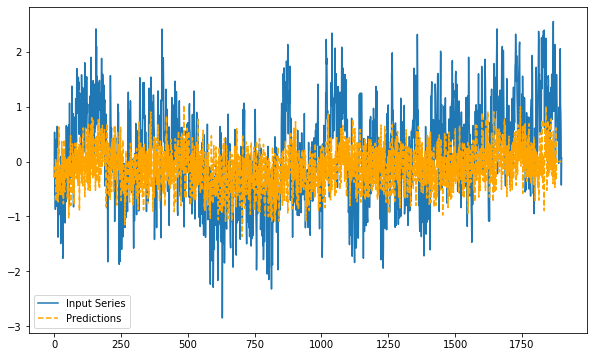

In [13]:
get_corr_mae_conv(data[:2000,:],
                  lookback,
                  pred_length, electrode_count=len(electrodes),
                  electrodes=electrodes,
                  target_electrode=target_electrode,
                  model=model)